In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from google.colab import files

In [ ]:
from itertools import combinations

In [ ]:
from scipy.stats import chi2_contingency, kruskal

# Data Import

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Big_Mart_Sales_Prediction_ABB_Assignment/train_file_Big_Mart.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Big_Mart_Sales_Prediction_ABB_Assignment/test_file_Big_Mart.csv")

In [ ]:
df_train['train_data'] = 1
df_test['train_data'] = 0

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)

# Data Quality Check

In [ ]:
df.isna().sum()

,0
Item_Identifier,0
Item_Weight,2439
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,4016
Outlet_Location_Type,0


# Missing Value Imputation

**Outlet Size**

In [ ]:
df[df['Outlet_Size'].isna()]['Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [ ]:
df[df['Outlet_Identifier']=='OUT010'][['Outlet_Location_Type','Outlet_Type']].head(1)

,Outlet_Location_Type,Outlet_Type
3,Tier 3,Grocery Store


In [ ]:
df[df['Outlet_Identifier']=='OUT045'][['Outlet_Location_Type','Outlet_Type']].head(1)

,Outlet_Location_Type,Outlet_Type
8,Tier 2,Supermarket Type1


In [ ]:
df[df['Outlet_Identifier']=='OUT017'][['Outlet_Location_Type','Outlet_Type']].head(1)

,Outlet_Location_Type,Outlet_Type
9,Tier 2,Supermarket Type1


OUT017, OUT045 both are located at 'Supermarket Type1' in 'Tier2' city. OUT010 is a 'Grocery Store' in 'Tier3' city.

In [ ]:
df[(df['Outlet_Location_Type']=='Tier 2') & (df['Outlet_Type']=='Supermarket Type1')]['Outlet_Size'].value_counts(normalize=True)

,proportion
Outlet_Size,
Small,1.0


As all stores at 'Supermarket Type1' in 'Tier2' city have 'Small' outlet size, we can impute this size for OUT017 and OUT045

In [ ]:
df[(df['Outlet_Location_Type']=='Tier 3') & (df['Outlet_Type']=='Grocery Store')]['Outlet_Size'].value_counts(normalize=True)

,proportion
Outlet_Size,


In [ ]:
df[(df['Outlet_Location_Type']=='Tier 3') & (df['Outlet_Type']=='Grocery Store')]['Outlet_Identifier'].unique()

array(['OUT010'], dtype=object)

In [ ]:
df[(df['Outlet_Location_Type']=='Tier 3')]['Outlet_Size'].value_counts(normalize=True)

,proportion
Outlet_Size,
Medium,0.666595
High,0.333405


In [ ]:
df[(df['Outlet_Type']=='Grocery Store')]['Outlet_Size'].value_counts(normalize=True)

,proportion
Outlet_Size,
Small,1.0


As all the 'Grocery Store' are of 'Small' size, we can impute this size for OUT010

In [ ]:
df['Outlet_Size'] = df['Outlet_Size'].fillna('Small')

**Item Weight**

We'll impute by missing values of the mean weight of the respective Item_Identifiers

In [ ]:
item_avg_weight = df.groupby("Item_Identifier")["Item_Weight"].transform("mean")

In [ ]:
df["Item_Weight"] = df["Item_Weight"].fillna(item_avg_weight)

In [ ]:
df.isna().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


# EDA

**Univariate**

Categorical

In [ ]:
obj_col = list(df.select_dtypes(include=['object']).columns)

In [ ]:
for col in obj_col:
  print('Number of Unique Categories in '+col+' :',df[col].nunique())

Number of Unique Categories in Item_Identifier : 1559
Number of Unique Categories in Item_Fat_Content : 5
Number of Unique Categories in Item_Type : 16
Number of Unique Categories in Outlet_Identifier : 10
Number of Unique Categories in Outlet_Size : 3
Number of Unique Categories in Outlet_Location_Type : 3
Number of Unique Categories in Outlet_Type : 4


In [ ]:
obj_col.remove('Item_Identifier')

In [ ]:
for col in obj_col:
  print('Unique Categories in '+col+' :',df[col].unique())

Unique Categories in Item_Fat_Content : ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Unique Categories in Item_Type : ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Unique Categories in Outlet_Identifier : ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Unique Categories in Outlet_Size : ['Medium' 'Small' 'High']
Unique Categories in Outlet_Location_Type : ['Tier 1' 'Tier 3' 'Tier 2']
Unique Categories in Outlet_Type : ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


Seems like there are some data collection mistake, becasue 'Low Fat', 'low fat' and 'LF' are actually trying to mean 'Low Fat'. Similarly 'Regular' and 'Reg' are equivalent.

In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'LF':'Low Fat', 'low fat':'Low Fat', 'Low Fat':'Low Fat',
    'reg':'Regular', 'Regular':'Regular'
})

Also we can club Item_Types in to meaningful categories

In [ ]:
group_map = {
    # Fresh Foods
    'Fruits and Vegetables': 'Fresh Foods_Veg',
    'Dairy': 'Fresh Foods_Veg',
    'Meat': 'Fresh Foods_Non_Veg',
    'Breads': 'Fresh Foods_Veg',
    'Seafood': 'Fresh Foods_Non_Veg',

    # Packaged / Processed Foods
    'Snack Foods': 'Packaged / Processed Foods',
    'Frozen Foods': 'Packaged / Processed Foods',
    'Canned': 'Packaged / Processed Foods',
    'Baking Goods': 'Packaged / Processed Foods',
    'Starchy Foods': 'Packaged / Processed Foods',
    'Breakfast': 'Packaged / Processed Foods',

    # Beverages
    'Soft Drinks': 'Beverages',
    'Hard Drinks': 'Beverages',

    # Household & Hygiene
    'Household': 'Household & Hygiene',
    'Health and Hygiene': 'Household & Hygiene',

    # Miscellaneous
    'Others': 'Miscellaneous'
}

df["Item_Group"] = df["Item_Type"].map(group_map)

In [ ]:
obj_col.append("Item_Group")

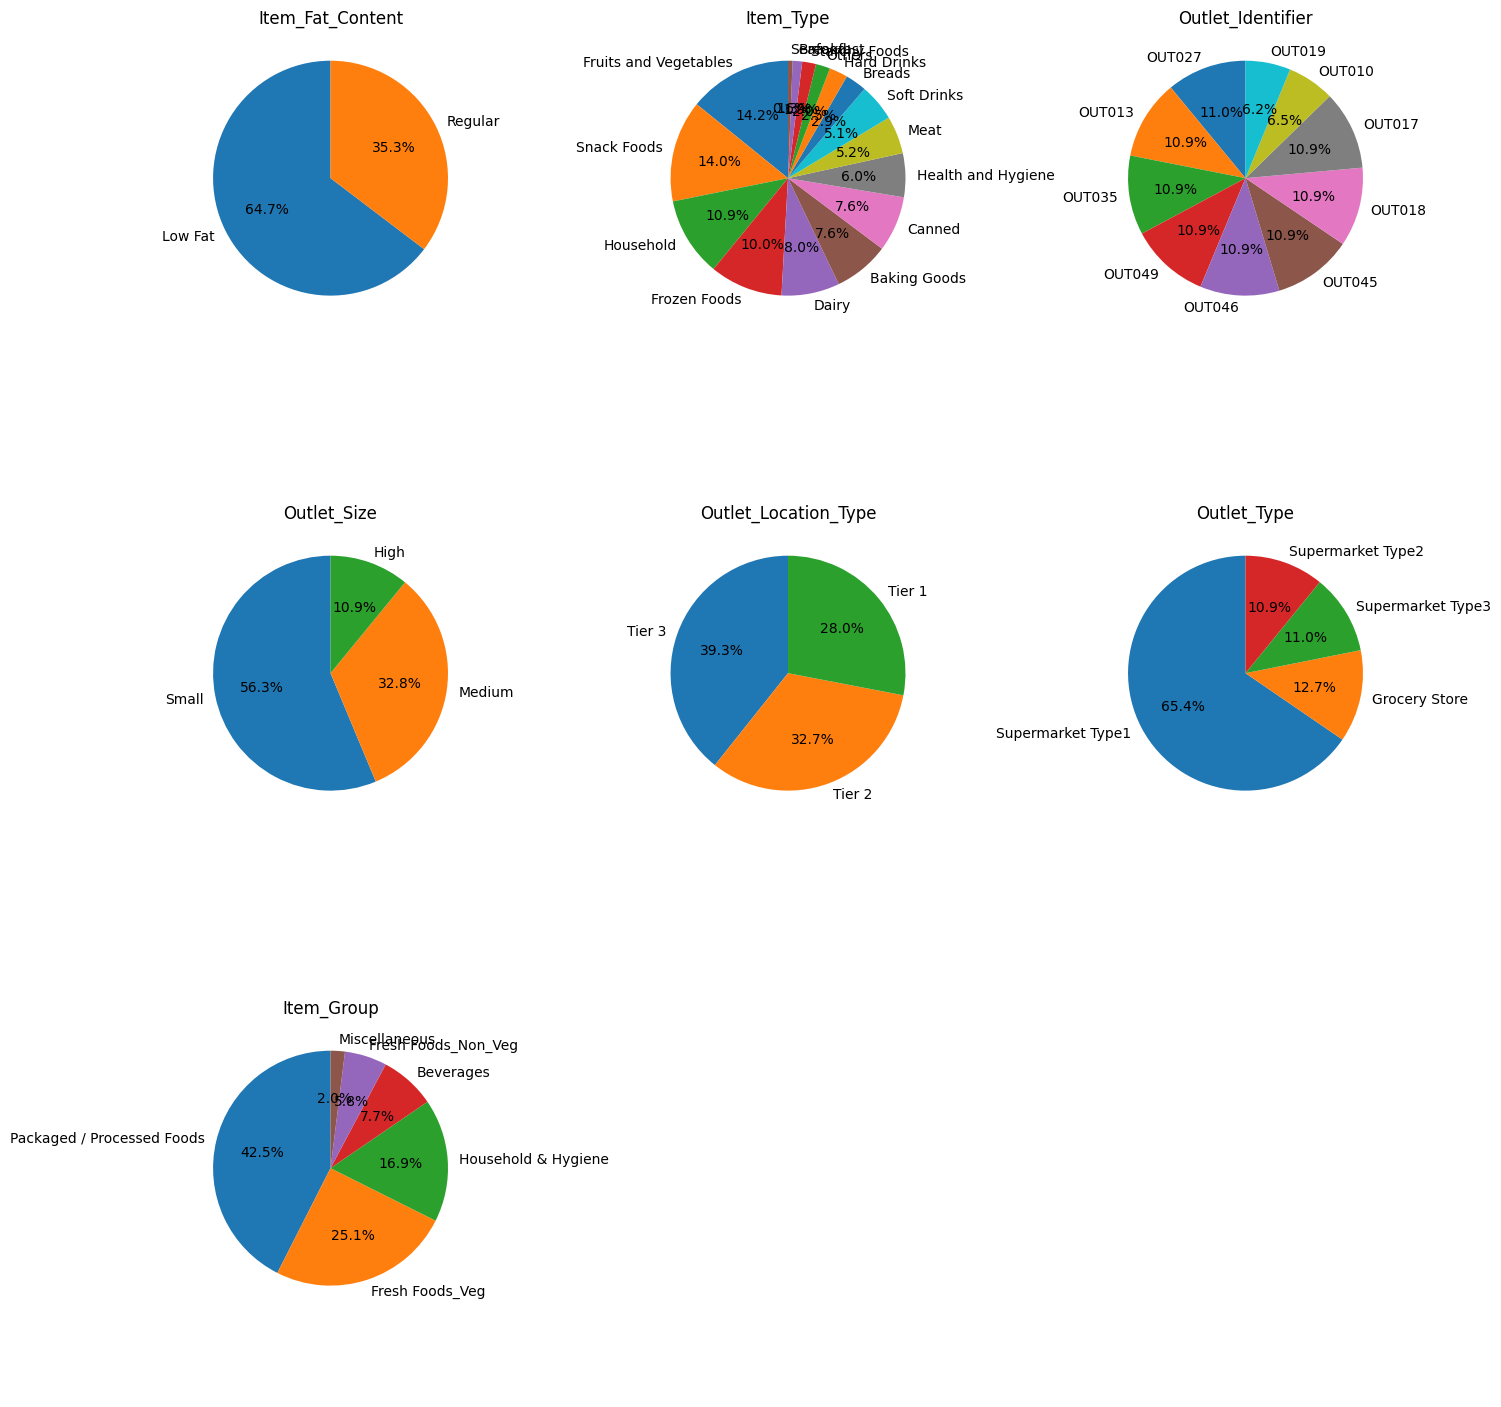

In [ ]:
n_cols = 3
n_rows = (len(obj_col) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(obj_col):
    ax = axes[i]
    counts = df[col].value_counts(normalize=True) * 100
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(col)

for j in range(len(obj_col), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

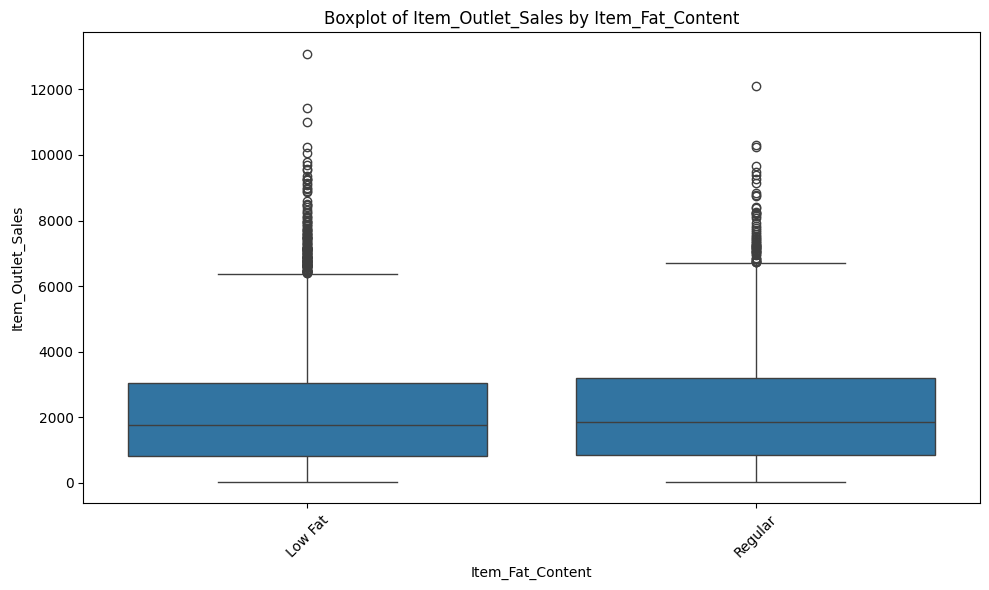

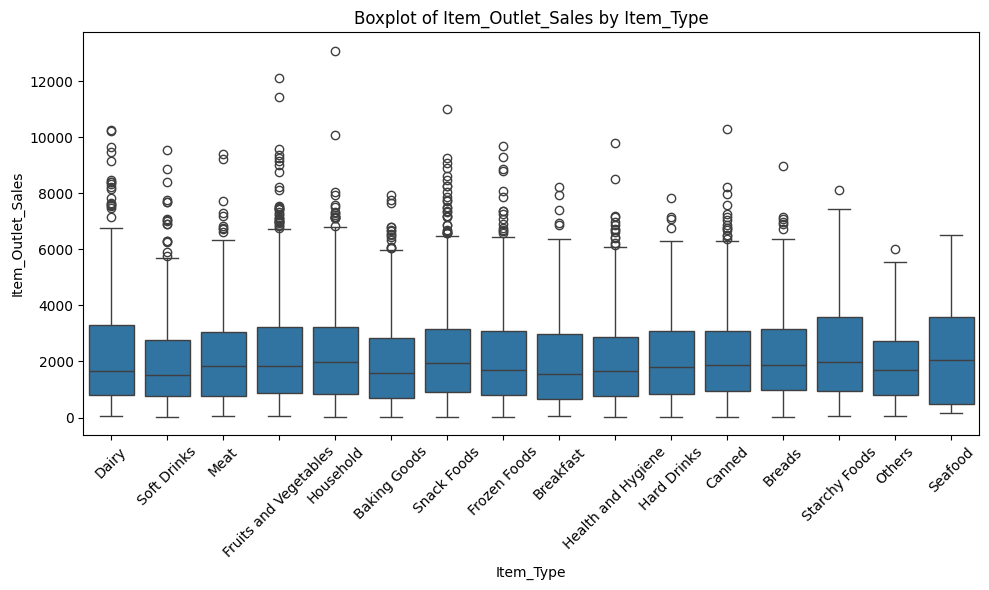

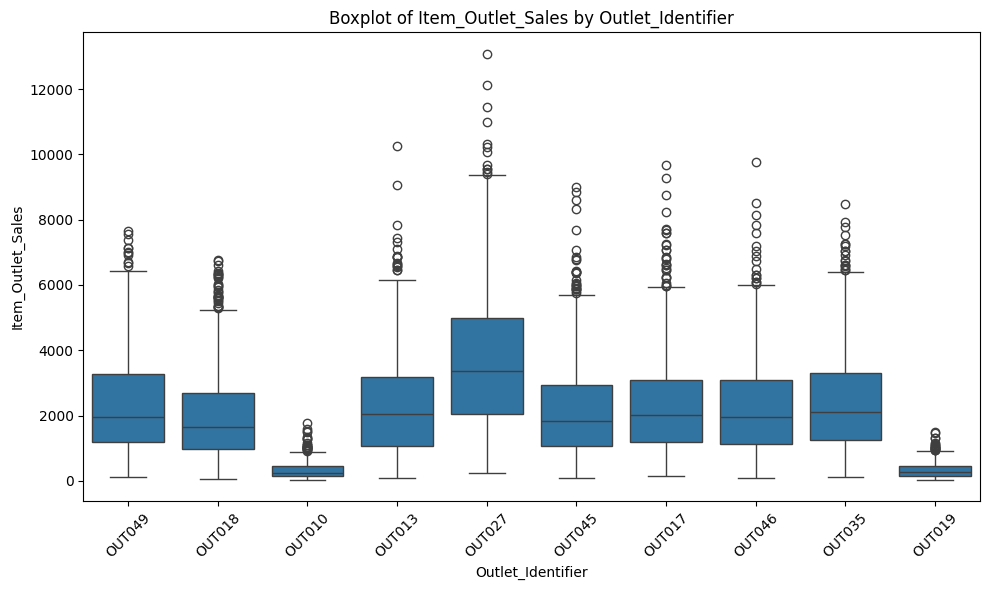

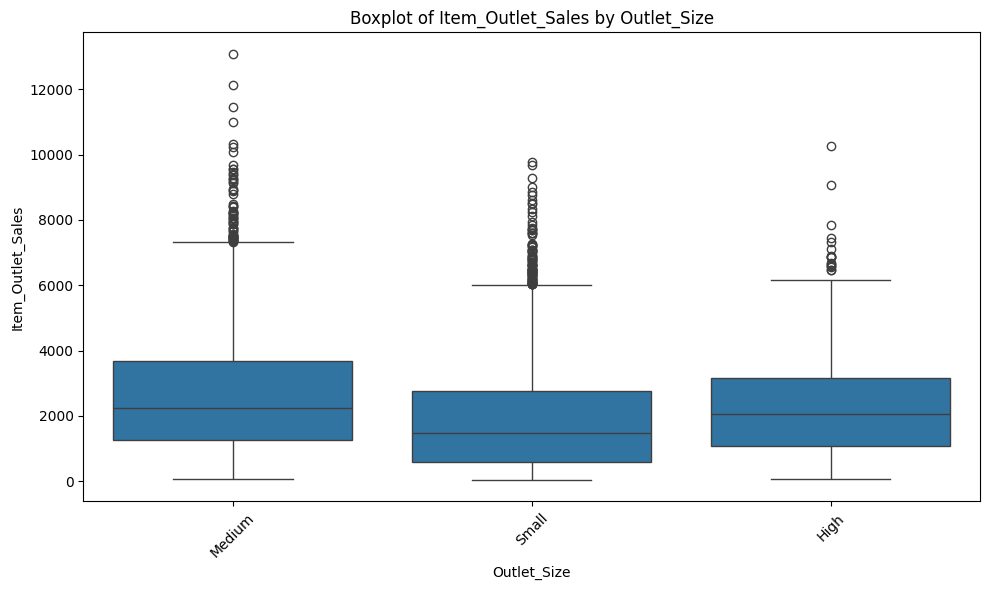

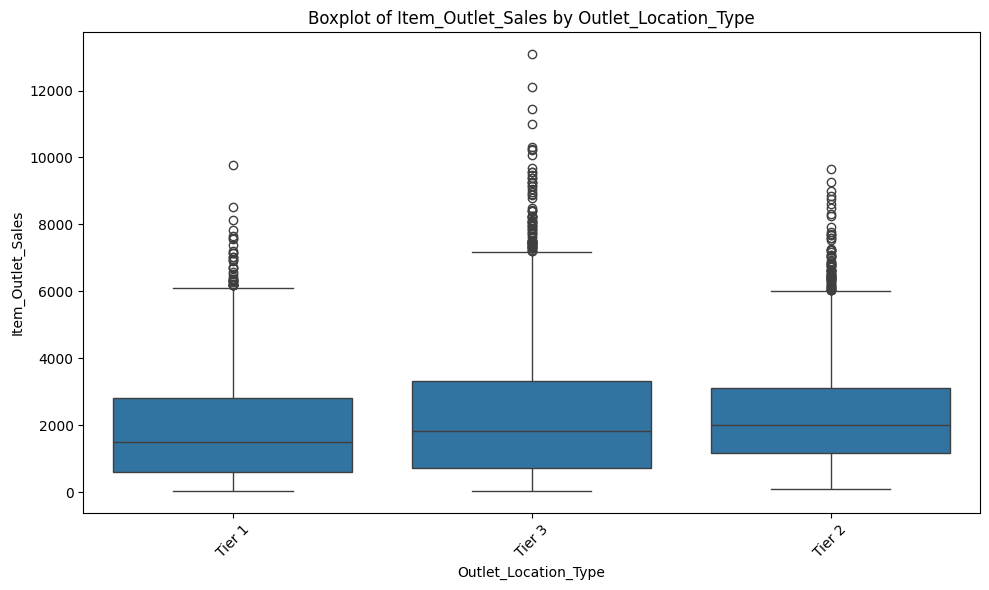

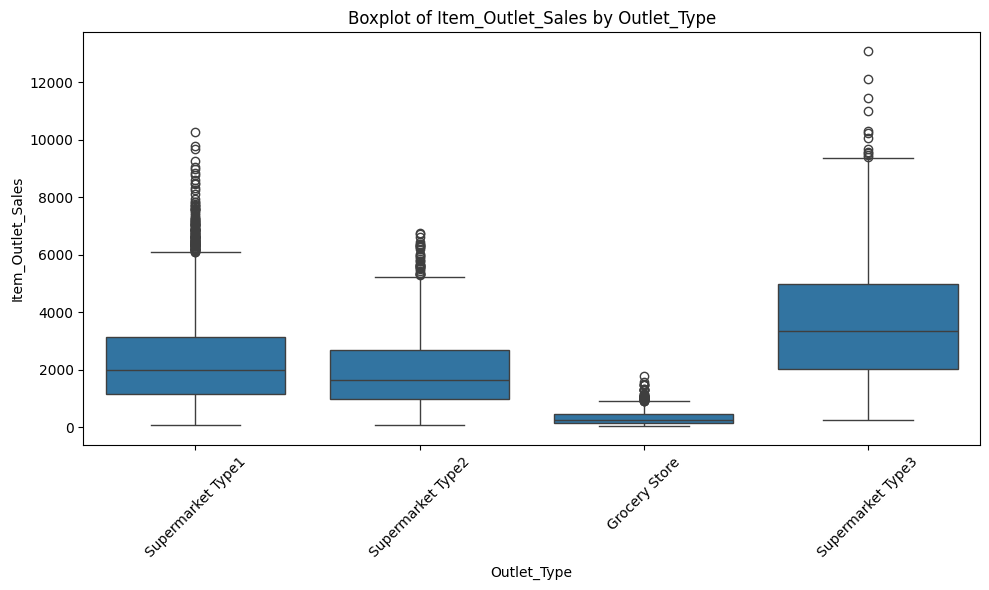

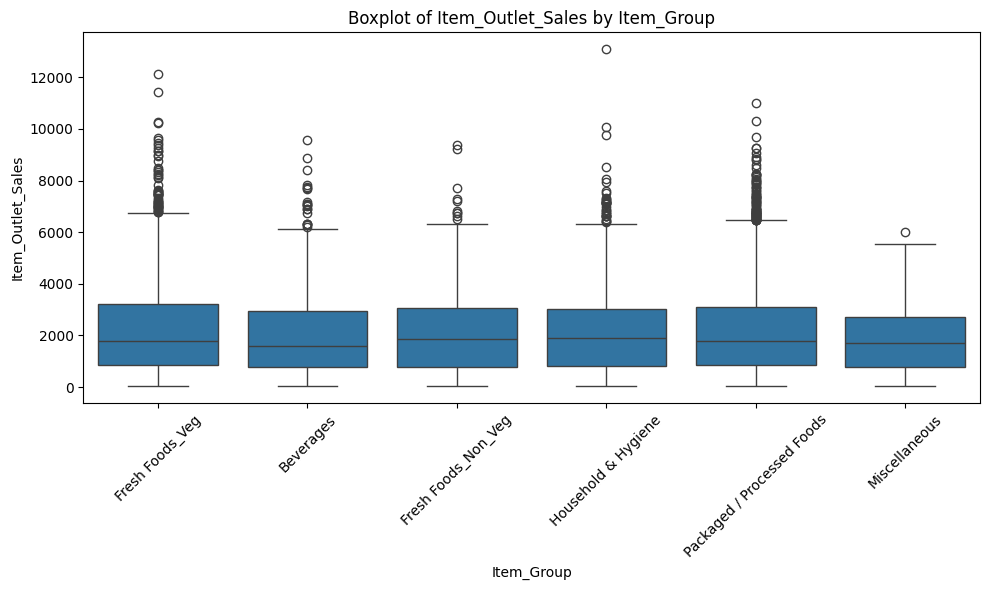

In [ ]:
target = "Item_Outlet_Sales"

for col in obj_col:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y=target, data=df)
    plt.title(f"Boxplot of {target} by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Continuous

In [ ]:
num_col = list(df.select_dtypes(exclude=['object']).columns)
# num_col.remove('Item_Outlet_Sales')
num_col.remove('train_data')

In [ ]:
num_col

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [ ]:
percentiles = [0, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 100]

summary_df = df[num_col].quantile([p/100 for p in percentiles]).transpose()

summary_df.columns = [f"{p}%" for p in percentiles]
summary_df.reset_index(inplace=True)
summary_df.rename(columns={"index": "Variable"}, inplace=True)

summary_df

,Variable,0%,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,100%
0,Item_Weight,4.555,6.655000,7.945000,8.710000,9.300000,10.895000,12.600000,14.300000,16.000000,16.750000,17.700000,19.350000,21.350000
1,Item_Visibility,0.000,0.011797,0.022828,0.027036,0.031961,0.041886,0.054021,0.067637,0.083529,0.094037,0.105626,0.137645,0.328391
2,Item_MRP,31.290,53.230580,85.142400,94.012000,102.527700,118.609800,142.247000,159.026200,177.934400,185.855600,194.579400,231.166800,266.888400
3,Outlet_Establishment_Year,1985.000,1985.000000,1987.000000,1987.000000,1997.000000,1998.000000,1999.000000,2002.000000,2004.000000,2004.000000,2007.000000,2009.000000,2009.000000
4,Item_Outlet_Sales,33.290,343.552800,666.465800,834.247400,1022.668800,1402.174800,1794.331000,2257.328320,2805.814360,3101.296400,3453.504600,4570.051200,13086.964800


1. As these are discrete values, either we have to convert
'Outlet_Establishment_Year' to categorical column to we have to enginner some feature like outlet age out of it.
2. Item_Visibility can't be zero. There is some data collection error must be happening
3. Percentile Distribution of 'Item_Outlet_Sales' is highly skewed, we have to take care of this skewness during modelling

'Outlet_Establishment_Year'

In [ ]:
df['Outlet_Establishment_Year'].value_counts(normalize=True)

,proportion
Outlet_Establishment_Year,
1985,0.171712
1987,0.109335
1999,0.109124
1997,0.109124
2004,0.109124
2002,0.108983
2009,0.108843
2007,0.108631
1998,0.065123


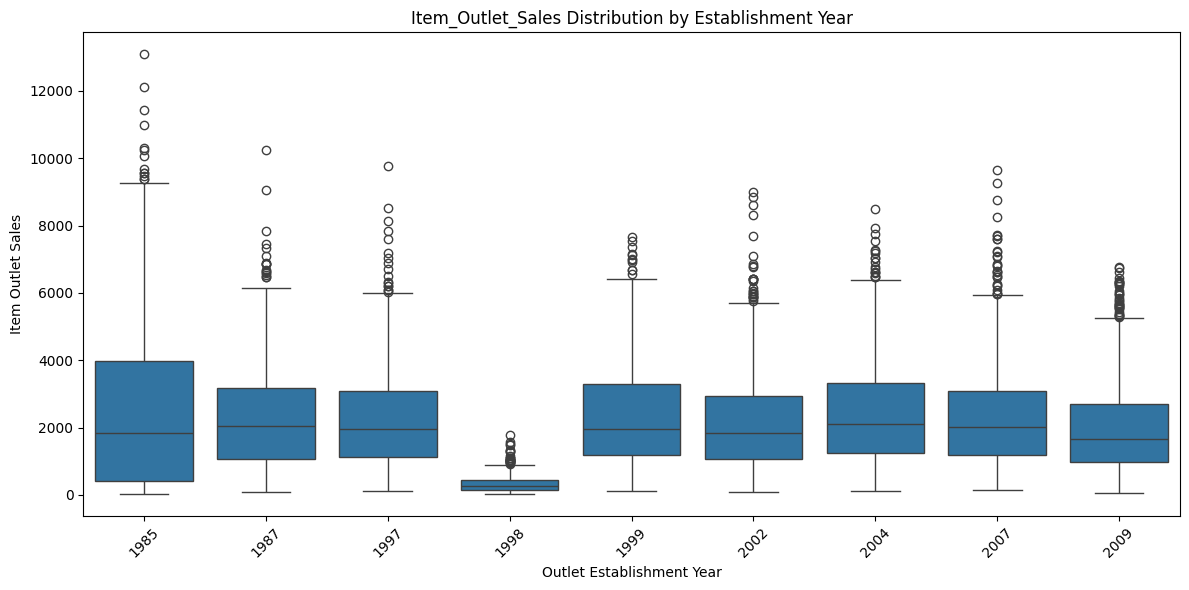

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="Outlet_Establishment_Year",
    y="Item_Outlet_Sales",
    data=df,
    order=sorted(df["Outlet_Establishment_Year"].unique())
)
plt.title("Item_Outlet_Sales Distribution by Establishment Year")
plt.xlabel("Outlet Establishment Year")
plt.ylabel("Item Outlet Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'Item_Visibility' [Correction]

In [ ]:
df['Item_Visibility'] = df['Item_Visibility'].replace(0, np.nan)

In [ ]:
median_visibility = df.groupby('Item_Identifier')['Item_Visibility'].transform("median")

In [ ]:
df["Item_Visibility"] = df["Item_Visibility"].fillna(median_visibility)

Plots for relationship of other continuous variables with "Item_Outlet_Sales"

In [ ]:
num_col.remove('Outlet_Establishment_Year')
num_col.remove('Item_Outlet_Sales')

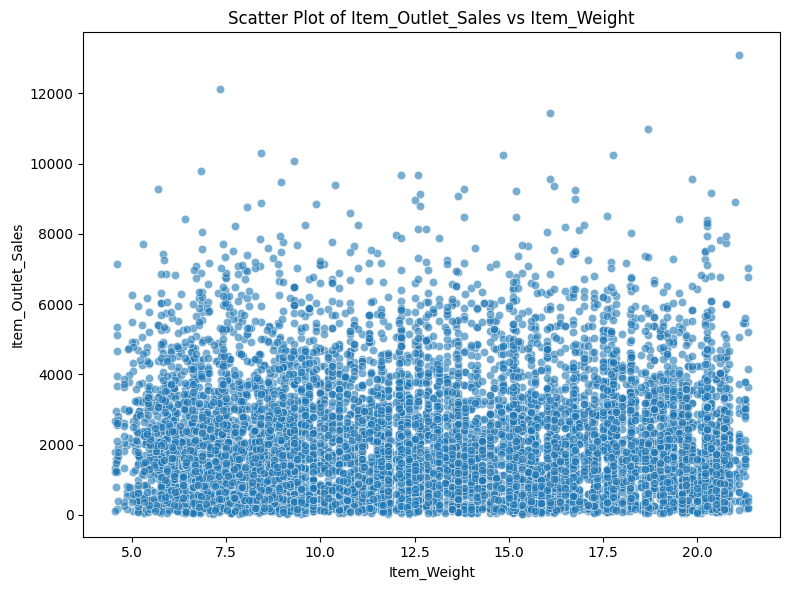

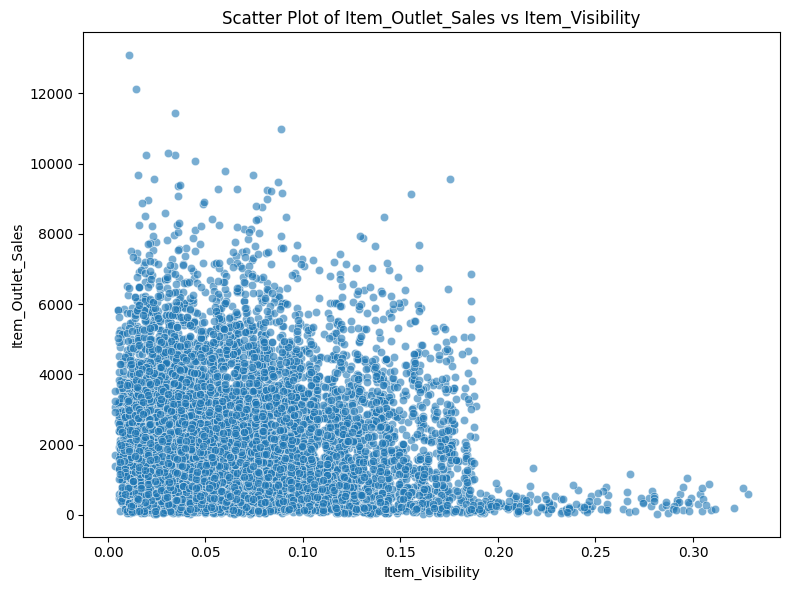

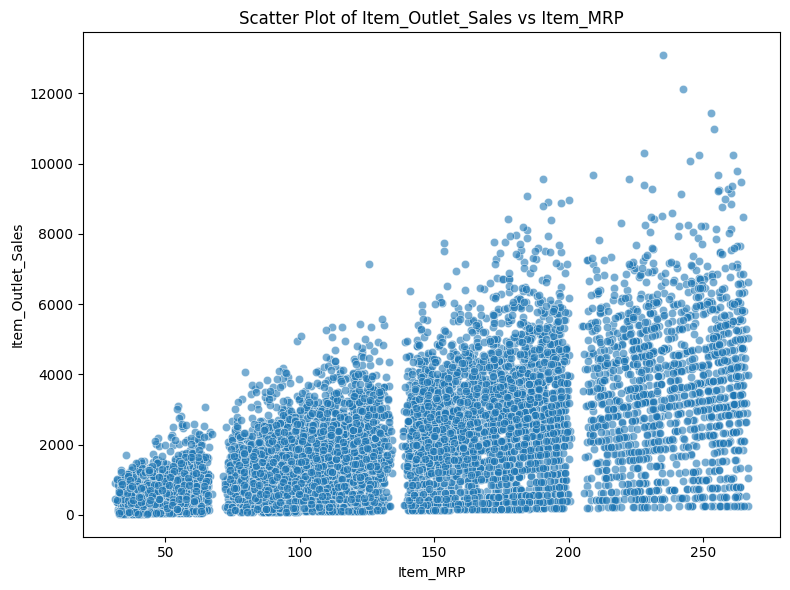

In [ ]:
target = "Item_Outlet_Sales"

for col in num_col:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[col], y=df[target], alpha=0.6)
    plt.title(f"Scatter Plot of {target} vs {col}")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

**Bi-Variate Analysis**

Categorical-Categorical

In [ ]:
obj_col.remove('Item_Group')

In [ ]:
def cramers_v(x,y):
  confusion_matrix = pd.crosstab(x,y)
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2/n
  r,k = confusion_matrix.shape
  cramers_v = np.sqrt(phi2/min(r-1,k-1))

  return cramers_v

In [ ]:
cramers_v_df = pd.DataFrame(index=obj_col, columns=obj_col)

for col1, col2 in combinations(obj_col, 2):
  cramers_v_df.loc[col1, col2] = cramers_v(df[col1], df[col2])

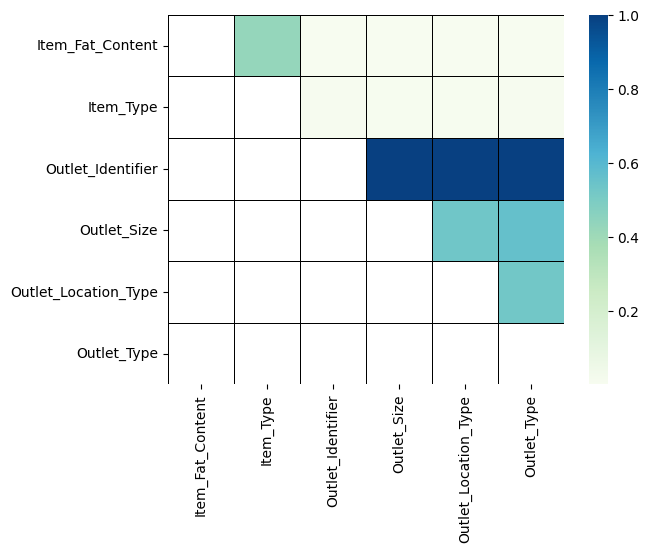

In [ ]:
sns.heatmap(cramers_v_df.astype(float), annot=False, cmap='GnBu', linewidths=0.5, linecolor='black')
plt.show()

Stronger Association between Some Categorical Variables can be noted here

Continuous-Categorical

In [ ]:
h_matrix = pd.DataFrame(index=obj_col, columns=num_col)
p_matrix = pd.DataFrame(index=obj_col, columns=num_col)

In [ ]:
for cat in obj_col:
  for cont in num_col:
    try:
      groups = [df[df[cat]==k][cont].dropna() for k in df[cat].dropna().unique()]
      h_stat, p_val = kruskal(*groups)
      h_matrix.loc[cat, cont] = h_stat
      p_matrix.loc[cat, cont] = p_val

    except:
      h_matrix.loc[cat, cont] = np.nan
      p_matrix.loc[cat, cont] = np.nan

In [ ]:
annot = p_matrix.applymap(lambda x: '*' if x<0.05 else '')

/tmp/ipython-input-3169220265.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = p_matrix.applymap(lambda x: '*' if x<0.05 else '')


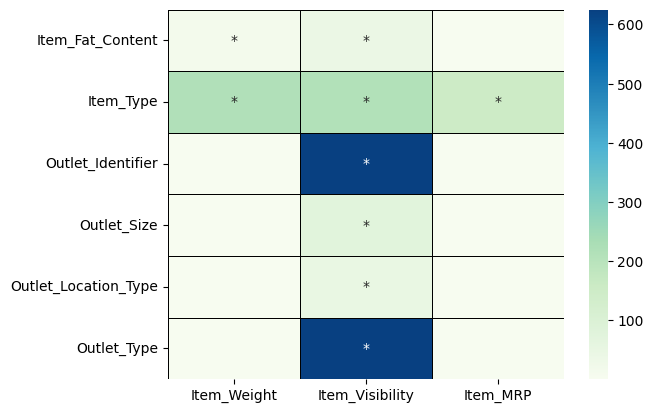

In [ ]:
sns.heatmap(h_matrix.astype(float), annot=annot, cmap='GnBu', linewidths=0.5, linecolor='black', fmt='')
plt.show()

For "*" marked cell : This categorical variable (Index) has a significant effect on the distribution of the continuous variable (column)

# Feature Engineering

Creating 'Outlet_Age' from 'Outlet_Establishment_Year'

In [ ]:
df['Outlet_Age'] = 2013 - df['Outlet_Establishment_Year']

'Item_Identifier'

In [ ]:
df['Item_Identifier'].nunique()

1559

In [ ]:
df['Item_Identifier'].value_counts(normalize=True)[0:10]

,proportion
Item_Identifier,
FDX13,0.000704
NCU29,0.000704
FDP21,0.000704
NCT53,0.000704
NCS29,0.000704
FDY14,0.000704
FDP33,0.000704
FDV38,0.000704
FDC14,0.000704


In [ ]:
df["Item_Prefix"] = df["Item_Identifier"].str[:2]
df["Item_Prefix"].value_counts()

,count
Item_Prefix,
FD,10201
NC,2686
DR,1317


'Item_Visibility' Adjusted (because for each store, the item visibility should sum up to 100%)

In [ ]:
df["Item_Visibility_Adjusted"] = (
    df.groupby("Outlet_Identifier")["Item_Visibility"]
      .transform(lambda x: x / x.sum())
)

In [ ]:
item_mean_vis = df.groupby("Item_Identifier")["Item_Visibility"].transform("mean")
df["Item_Visibility_MeanRatio"] = df["Item_Visibility"] / item_mean_vis

Price Per Weight

In [ ]:
df['Price_Per_Weight'] = df['Item_MRP'] / df['Item_Weight']

MRP Bins

In [ ]:
df['MRP_bin'] = pd.qcut(df['Item_MRP'], 5, labels=False, duplicates='drop')

Interaction Between Item_MRP and Item_Visibility

In [ ]:
df['Intr_Item_MRP_Item_Visibility'] = df['Item_MRP'] * df['Item_Visibility']

Interaction Between Outlet_Age and Outlet_Size

In [ ]:
df['Intr_Outlet_Age_Outlet_Size'] = df['Outlet_Age'].astype(str) + "_" + df['Outlet_Size']

Saving The Prepared Data

In [ ]:
df.to_csv("Big_Mart_Prepared_Data_Train_Test.csv", index=False)
files.download("Big_Mart_Prepared_Data_Train_Test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>